<div style="text-align: center; line-height: 0; padding-top: 2px;">
  <img src="https://www.quantiaconsulting.com/logos/quantia_logo_orizz.png" alt="Quantia Consulting" style="width: 600px; height: 250px">
</div>

# BigQuery API (python) - with exercises

In this notebook, you will learn how to use the [__BigQuery API__](https://googleapis.dev/python/bigquery/latest/index.html) for python.

In particular you will learn how to:

  - create a storage bucket, load the CSV file (LAB __exercise__)
  - create a dataset
  - create a table (ingest CSV data from Cloud Storage)
  - query a table
  - query a table using the [__pandas-gbq__](https://pandas-gbq.readthedocs.io/en/latest/index.html) library, plot the results
  - delete a bucket (LAB __exercise__)
  - delete a table
  - delete a dataset 

### Install the libraries

In [34]:
pip install -q google-cloud

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install -q google-cloud-storage

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install -q google-cloud-bigquery

Note: you may need to restart the kernel to use updated packages.


### Setup the environment

In [37]:
# Import the python libraries

import os
from google.cloud import storage
from google.cloud import bigquery

In [38]:
# Import the .json credentials and set the environment variable (TODO:student)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./<YOUR-CREDENTIALS>.json"

## Create a bucket to upload the CSV file (LAB exercise)

__Note__: in order to avoid conflicts with your colleagues, please name the bucket_id using your \<surname\> as initial part of the id

In [60]:
# Get the client reference

client = <TODO>

In [61]:
# Set the bucket paramenters
# We would like to have a standard bucket located in Europe (multi-region)

project_id = <TODO>
bucket_id = <TODO>
bucket_location = <TODO>
storage_class = <TODO>


# Set the file path and object name

file_path = <TODO>
blob_name = <TODO>

In [ ]:
# 1. Declare a bucket entity, set prameters (project, location, storage_class)
<TODO>

# 2. Bucket creation (API request)
# Remember: the bucket-id must be unique among all the existing Cloud Storage buckets all over the world.
#           If you get a creation error, try to change the bucket-id parameter with another one.
<TODO>

# 3. Upload the CSV file on the bucket
<TODO>

## Create a dataset

In [43]:
# Construct a BigQuery client object.

client = bigquery.Client()

__Note__: in order to avoid conflicts with your colleagues, please name the dataset_id by changing "FILM_DS_PYTHON" with "\<surname\>_FILM_DS_PYTHON"

In [44]:
# Set the "dataset_id" and the "location" of the data (TODO:student)

dataset_id = "{}.FILM_DS_PYTHON".format(client.project)
location = "EU"

print("Dataset id: " + dataset_id)

Dataset id: preparazione-lezione-gcp.FILM_DS_PYTHON


In [45]:
# Construct a full Dataset object to send to the API.

dataset = bigquery.Dataset(dataset_id)
dataset.location = location

In [46]:
# Send the dataset to the API for creation, with an explicit timeout.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.

dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

Created dataset preparazione-lezione-gcp.FILM_DS_PYTHON


## Create a BigQuery table by ingesting CSV data

In [47]:
# Set "table_id" to the ID of the table to create (TODO:student)

table_id = "{}.{}.NETFLIX".format(client.project, dataset.dataset_id)

print("Table id: " + table_id)

Table id: preparazione-lezione-gcp.FILM_DS_PYTHON.NETFLIX


In [48]:
# Define the BigQuery job (reference: https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.LoadJobConfig.html)

job_config = bigquery.LoadJobConfig(
    autodetect=True, # schema autodetection
    skip_leading_rows=1,
    allow_quoted_newlines=True, # Allow quoted data containing newline characters (CSV only)
    allow_jagged_rows=True, # Allow missing trailing optional columns (CSV only)
    source_format=bigquery.SourceFormat.CSV, # The source format defaults to CSV, so the line below is optional.
)

In [49]:
# Set the "uri" location of the data in Cloud Storage

uri = "gs://" + bucket_id + "/" + blob_name

print("Cloud Storage uri: " + uri)

Cloud Storage uri: gs://bigquery_film_example_python/netflix_titles.csv


In [50]:
# Call the API, execute the job

load_job = client.load_table_from_uri(
    uri, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = client.get_table(table_id)  # Make an API request.

print("Loaded {} rows and {} columns to {}".format(destination_table.num_rows, len(destination_table.schema), table_id))

Loaded 7787 rows.


## Make a query

In [51]:
# Define the query text

query = """
    SELECT type, count(*) AS CNT
    FROM `""" + table_id + """`
    WHERE release_year >= 2015 AND country = "United Kingdom"
    GROUP BY type
"""

print(query)


    SELECT type, count(*) AS CNT
    FROM `preparazione-lezione-gcp.FILM_DS_PYTHON.NETFLIX`
    WHERE release_year >= 2015 AND country = "United Kingdom"
    GROUP BY type



In [52]:
# Run the query

query_job = client.query(query)  # Make an API request.

In [53]:
# Print the results

print("The query data:")
for row in query_job:
    # Row values can be accessed by field name or index.
    print("type={}, count={}".format(row[0], row["CNT"]))

The query data:
type=Movie, count=144
type=TV Show, count=155


## Make the same query using the pandas-gbq library

In [54]:
pip install -q pandas_gbq

Note: you may need to restart the kernel to use updated packages.


In [55]:
import pandas_gbq

# Run a Standard SQL query using the environment's default project
df = pandas_gbq.read_gbq(query, dialect='standard')

print(df)

Downloading: 100%|██████████| 2/2 [00:00<00:00, 10.65rows/s]

      type  CNT
0    Movie  144
1  TV Show  155


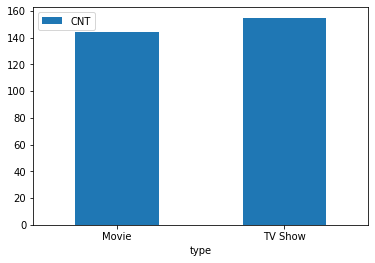

In [56]:
# Plot a simple data visualization

ax = df.plot.bar(x='type', y='CNT', rot=0)

## Delete the bucket (LAB exercise)

In [3]:
# Delete the bucket (LAB exercise)

# Get client reference
storageClient = storage.Client()

<TODO>

## Clean up

In [58]:
# Delete the Table

client.delete_table(table_id, not_found_ok=True)  # Make an API request.
print("Deleted table '{}'.".format(table_id))

Deleted table 'preparazione-lezione-gcp.FILM_DS_PYTHON.NETFLIX'.


In [59]:
# Delete the dataset

client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)

print("Deleted dataset '{}'.".format(dataset_id))

Deleted dataset 'preparazione-lezione-gcp.FILM_DS_PYTHON'.


##### ![Quantia Tiny Logo](https://www.quantiaconsulting.com/logos/quantia_logo_tiny.png) 2021 Quantia Consulting, srl. All rights reserved.